In [1]:
# This Notebook contains contents for Data Science Assessment (with Fraud Data).
# Main Contents are as follows:
# 1. Preliminaries
# 2. Exploration of dataset  
# 3. Improvement steps
# 4. Prediction of holdout data


#1. Preliminaries
#1. 1) Importing packages and Loading Dataset, define functions
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset 
import random
random_seed=random.randint(0,2000)

import sklearn
import imblearn
from imblearn.over_sampling import ADASYN
# Monkey patch for fixing error importing LogisticRegression function
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, NuSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
import seaborn as sns

def time_gap_calculation(Target_df):
    signup_df = pd.to_datetime(Target_df['signup_time'])
    purchase_df = pd.to_datetime(Target_df['purchase_time'])
    time_diff = (purchase_df - signup_df).dt.total_seconds()/3600
    return time_diff

def IP_Country_map(Target_df, Cntry_df):
    output = Target_df['ip_address'].apply(lambda x: Cntry_df.loc[(Cntry_df['lower_bound_ip_address'] <= x) 
                                                                    & (x <= Cntry_df['upper_bound_ip_address']), 'country'].values[0] 
                                             if not Cntry_df.loc[(Cntry_df['lower_bound_ip_address'] <= x) & 
                                                                 (x <= Cntry_df['upper_bound_ip_address']), 'country'].empty else None)
    return output
    
def count_country(y): 
    counter = Counter(y)
    
    # Sort the items in the counter dictionary by frequency in descending order
    sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

    data = {'Country': list(sorted_counter.keys()), 'n': list(sorted_counter.values())}
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    # for k, v in sorted_counter.items():
    #     print('Country=%s, n=%d (%.3f%%)' % (k, v, v / len(y)))
    
    # # Plot the sorted counter
    # plt.bar(sorted_counter.keys(), sorted_counter.values())
    # plt.show()
    
    # Return the DataFrame
    return df

def fraud_detection_accuracy(Actual, Predicted):
    comp_df = pd.DataFrame({'Actual': Actual, 'Predicted': Predicted})
    detected_frauds = len(comp_df[(comp_df['Actual'] == 1) & (comp_df['Predicted'] == 1)])
    detected_normal = len(comp_df[(comp_df['Actual'] == 0) & (comp_df['Predicted'] == 0)])
    total_number_of_frauds = len(comp_df[comp_df['Actual']==1])
    total_number_of_normal = len(comp_df[comp_df['Actual']==0])
    print(f'The number of properly predicted fraudulent : {detected_frauds} / {total_number_of_frauds}')
    print('\n')
    print(f'The number of properly predicted normal : {detected_normal} / {total_number_of_normal}')
    print('\n')

def prepare_training_multi(target_df, random_seed, mode='normal',size_normal=1, size_fraud=1):
    X = target_df.drop('class',axis=1)
    y = target_df['class']
    
    num_cols = X.select_dtypes(exclude=['object']).columns
    cat_cols = X.select_dtypes(include=['object']).columns
    
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    
    scaler = StandardScaler()
    #X = scaler.fit_transform(X)
    X[num_cols] = scaler.fit_transform(X[num_cols])
    X[cat_cols] = scaler.fit_transform(X[cat_cols])
    
    if mode == 'normal':
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=random_seed)
    
    elif mode == 'over':
        ADASYN_strategy = {0:size_normal, 1:size_normal}
        X_adasyn, y_adasyn = ADASYN(sampling_strategy = ADASYN_strategy).fit_resample(X,y)
        X_train, X_test, y_train, y_test = train_test_split(X_adasyn, y_adasyn, test_size = 0.3, random_state=random_seed)
        
    
    return X_train, X_test, y_train, y_test

def prepare_training_one(target_df, random_seed):
    X = target_df.drop('class',axis=1)
    y = target_df['class']
    
    num_cols = X.select_dtypes(exclude=['object']).columns
    cat_cols = X.select_dtypes(include=['object']).columns
    
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    
    scaler = StandardScaler()
    #X = scaler.fit_transform(X)
    X[num_cols] = scaler.fit_transform(X[num_cols])
    X[cat_cols] = scaler.fit_transform(X[cat_cols])
    
    X_train = X[y == 1].sample(frac=0.5, random_state=random_seed)
    y_train = y[X_train.index]
    # Selecting the rest of instances belonging to class 1 and all instances belonging to class 0 for df2
    X_test_1 = X[y == 1].drop(X_train.index)
    X_test_0 = X[y == 0]

    # Concatenating the two dataframes for df2
    X_test = pd.concat([X_test_1, X_test_0])
    y_test = y[X_test.index]
    
    return X_train, X_test, y_train, y_test

# csv files can be imported by 'read_csv' of pandas

Raw_df = pd.read_csv('Candidate_tech_evaluation_candidate_copy_data science_fraud.csv')

#1. 2) Mapping IP Address to Country 

# At first, I get bounds and corresponding country names by importing map file.
# xlsx files can be imported by 'read_excel' of pandas

Cntry_df = pd.read_excel('Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx')

# I can add new column named 'cntry' corresponding to the 'ip_address' in 'Raw_df'.
# My application of lambda function to define a value for 'cntry' column by referring to 'ip_address' column is as follows: 
# If 'ip_address' represented as 'x' is greater than or equal to 'upper_bound_ip_address' of 'Cntry_df' 
# and 'x' is less than or equal to 'lower_bound_ip_address' of 'Cntry_df',
# then'cntry' of 'Raw_df' is filled by 'country' of 'Cntry_df'
# If the 'ip_address' is not belonging to bound defined in map file, 'None' type value (null) is filled.
# Since this mapping will be done in holdout data, I used above-mentioned function for it. 



Raw_df['cntry'] = IP_Country_map(Raw_df, Cntry_df)



# 1. 3) Checking completeness of dataset

# I can apply any data-driven approach for the complete data set. 
# By 'Dataframe.isnull().sum(), I can check if there is any column including a null value. 

if (Raw_df.isnull().sum().sum() == 0):
    print('There is no null value in dataset.')
else:
    print('Some values are null, you should deal with it first')

# I can check which column contains null values. 

print(Raw_df.isnull().sum())

# There are null values in 'cntry' column, which results from IP address mapping.
# I can impute 'cntry' column of records not within the list as 'Unknown'

Raw_df['cntry'] = Raw_df['cntry'].fillna('Unknown')

if (Raw_df.isnull().sum().sum() == 0):
    print('There is no null value in dataset.')
else:
    print('Some values are null, you should deal with it first')

# Now I have a complete dataset.

Some values are null, you should deal with it first
Unnamed: 0            0
user_id               0
signup_time           0
purchase_time         0
purchase_value        0
device_id             0
source                0
browser               0
sex                   0
age                   0
ip_address            0
class                 0
cntry             17418
dtype: int64
There is no null value in dataset.


The size of normal class is 108735, and that of fraud class is 11265


The accuracy of baseline model : 0.9052777777777777


The number of properly predicted fraudulent : 0 / 3410




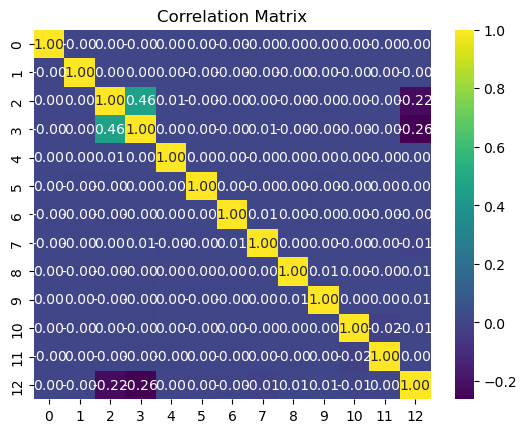



signup_time      109111
purchase_time    100058
device_id        110599
source                3
browser               5
sex                   2
cntry               177
dtype: int64




In [4]:
import seaborn as sns
#2. Exploration of dataset  
#2. 1) Class imbalance 
# Regarding high-level problem statements, the target dataset is a mixture of normal and fraudulent transactions. 
# In the real-world, most of transactions are normal, and only a few transactions are fraudulent. 
# Such class imbalance can be observed in datasets other than the fraud dataset like defects in a manufacturing dataset. 
# I can check size of each class as follows:

size_normal = len(Raw_df[(Raw_df['class'] == 0)])
size_fraud = len(Raw_df[(Raw_df['class'] == 1)])

print(f'The size of normal class is {size_normal}, and that of fraud class is {size_fraud}') 
print('\n')
# The number of normal transactions dominates that of fraudulent ones.
# Since conventional classifier is learned by differences between each class, this imbalance makes it hard to get a rigorous classifier.
# For example, I can check it with a baseline model, which is naive and lack of pre-processing. 
# I did only quantization of categorical features and normalized input for the baseline model.

X = Raw_df.drop('class', axis=1)
y = Raw_df['class']

num_cols = X.select_dtypes(exclude=['object']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# This step is the quantization of categorical features. 'LabelEncoder' gives an incremental value for each categorical value.

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=random_seed)

model_baseline = LogisticRegression()
model_baseline.fit(X_train,y_train)

# I can check the accuracy of model by as follows.

model_baseline_Accuracy = model_baseline.score(X_test, y_test)
print(f'The accuracy of baseline model : {model_baseline_Accuracy}')
print('\n')

# Accuracy itself is about 0.9. Since I want to detect fraudulent transactions, however, I need to check the number of detected fraudulents.

fraud_proba = model_baseline.predict_proba(X_test)
fraud_label = model_baseline.predict(X_test)

comp_df = pd.DataFrame({'Actual': y_test, 'Predicted': fraud_label})
detected_frauds = len(comp_df[(comp_df['Actual'] == 1) & (comp_df['Predicted'] == 1)])
total_number_of_frauds = len(comp_df[comp_df['Actual']==1])
print(f'The number of properly predicted fraudulent : {detected_frauds} / {total_number_of_frauds}')
print('\n')

# The baseline model cannot detect any fraudulent transaction, which stems from the class imbalance.
# Meanwhile, such imbalance makes it hard to derive a proper correlation between input and output. 

y_ = np.reshape(y, (-1,1))
X_and_Y = np.concatenate((X,y_), axis=1)

correlation_matrix = np.corrcoef(X_and_Y, rowvar=False)
#correlation_matrix = X_and_Y.corr()
# Plot the correlation matrix using seaborn
sns.heatmap(correlation_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=range(len(correlation_matrix)), yticklabels=range(len(correlation_matrix)))
plt.title('Correlation Matrix')
plt.show()
print('\n')

# Relavance between Input variables (0-11) and class label (12) can hardly be calculated. 

#2. 2) Cardinality of categorical value
# As you can see in the quantization of the categorical value step, LabelEncoder gives incremental values. 
# If the cardinality of categorical value is too high, it can be hard to get a relevant pattern for defining the class. 

print(Raw_df[cat_cols].nunique())
print('\n')
# I observed many categories in 'signup_time', 'purchase_time', 'device_id', 'cntry'
# Additional feature engineering is required. 
# Two main issues of dataset were : 1) imbalanced data, 2) Too many categorical value 

In [5]:
#3. Improvement steps
#3. 1) Application of Oversampling and giving different cost between classes 
# I can carry out oversampling merely by randomly selecting a minority class since it can trigger overfitting to oversampled instances.
# Instead, I adopted ADASYN (Adaptive Synthetic Sampling Approach) which generates synthetic instances based on the minority class. 
# SMOTE (Synthetic Minority Over-sampling Technique) is a well-known method performing a similar task.  

ADASYN_strategy = {0:size_normal, 1:size_normal} # This policy results in the same number of normal and fraud classes,
# by generating more synthetic instances of the fraud class. 

X_adasyn, y_adasyn = ADASYN(sampling_strategy = ADASYN_strategy).fit_resample(X,y)

X_tr_ADASYN, X_ts_ADASYN, y_tr_ADASYN, y_ts_ADASYN = train_test_split(X_adasyn, y_adasyn, test_size = 0.3,random_state=random_seed)
# Even though I use the same random seed as the previous split, actual training and test set can be different since I generated
# the synthetic data by ADASYN

# now I can repeat the same step above in #2. 3)

model_ADASYN = LogisticRegression()
model_ADASYN.fit(X_tr_ADASYN, y_tr_ADASYN)

# I am interested in only the number of fraudulent in original dataset detected by revised classifier.
# Thus, I used the original test data and test label.
fr_lab_ADASYN = model_ADASYN.predict(X_test)

comp_df_ADASYN = pd.DataFrame({'Actual': y_test, 'Predicted': fr_lab_ADASYN})
detected_frauds_ADASYN = len(comp_df_ADASYN[(comp_df_ADASYN['Actual'] == 1) & (comp_df_ADASYN['Predicted'] == 1)])
total_number_of_frauds_ADASYN = len(comp_df_ADASYN[comp_df_ADASYN['Actual']==1])
print(f'The number of properly predicted fraudulent : {detected_frauds_ADASYN} / {total_number_of_frauds_ADASYN}')
print('\n')
# The same step using weighting between classes can be done as follows.

model_weighted = LogisticRegression(class_weight = 'balanced') # 'balanced' argument implicitly gives weight inverse proportional to class size.
model_weighted.fit(X_train, y_train) 

fr_lab_weighted = model_weighted.predict(X_test)


comp_df_weighted = pd.DataFrame({'Actual': y_test, 'Predicted': fr_lab_weighted})
detected_frauds_weighted = len(comp_df_weighted[(comp_df_weighted['Actual'] == 1) & (comp_df_weighted['Predicted'] == 1)])
total_number_of_frauds_weighted = len(comp_df_weighted[comp_df_weighted['Actual']==1])
print(f'The number of properly predicted fraudulent : {detected_frauds_weighted} / {total_number_of_frauds_weighted}')

# Although ADASYN shows slightly better performance, this dominance can be varied by dataset.
# In terms of Computational efficiency, ADASYN requires more computing resources.

#3. 2) Feature engineering
# At first, I need to drop redundant features which give a burden of calculation and hinder the performance of algorithm. 
# Unnamed: 0 column is not labeled what it means. Maybe it is an index or annotation based on order. 
# user_id is not a relevant feature since the fraud can generate user_id easily. 
# ip_address is mapped as cntry column. Thus I can drop it also. 
# Let's check if the performance of classifier is maintained despite of deletion of these features
# The column number of three elements are 0, 1, 10 
X_train_drop = np.delete(X_train, [0,1,10], axis=1)
X_test_drop = np.delete(X_test, [0,1,10], axis=1)

model_weighted_drop = LogisticRegression(class_weight = 'balanced')
model_weighted_drop.fit(X_train_drop, y_train)
fr_lab_weighted_drop = model_weighted_drop.predict(X_test_drop)

comp_df_weighted_drop = pd.DataFrame({'Actual': y_test, 'Predicted': fr_lab_weighted_drop})
detected_frauds_weighted_drop = len(comp_df_weighted_drop[(comp_df_weighted_drop['Actual'] == 1) & (comp_df_weighted_drop['Predicted'] == 1)])
total_number_of_frauds_weighted_drop = len(comp_df_weighted_drop[comp_df_weighted_drop['Actual']==1])
print(f'The number of properly predicted fraudulent : {detected_frauds_weighted_drop} / {total_number_of_frauds_weighted_drop}')

# I can reduce dimensionality by no information loss.



The number of properly predicted fraudulent : 2521 / 3410


The number of properly predicted fraudulent : 2366 / 3410
The number of properly predicted fraudulent : 2360 / 3410


In [9]:
# In addition, I do feature Engineering for Categorical values with high cardinality.
# The first group is signup_time and purchase_time. 
# I want to analyze not raw values of two features, but the difference between two datetimes. 
# I can calculate and compare the difference as follows. 

time_diff_df = time_gap_calculation(Raw_df)
mean_normal_time = time_diff_df.loc[(Raw_df['class']==0)].mean()
std_normal_time = time_diff_df.loc[(Raw_df['class']==0)].std()
mean_fraud_time = time_diff_df.loc[(Raw_df['class']==1)].mean()
std_fraud_time = time_diff_df.loc[(Raw_df['class']==1)].std()

print(f'Mean and std_dev time gap of normal transaction : {mean_normal_time} / {std_normal_time}')
print('\n')
print(f'Mean and std_dev time gap of fraud transaction : {mean_fraud_time} / {std_fraud_time}')

# The time gap between the two classes is significant.

# The next one is device_id. If someone create many user_id with the same device, it can be suspicious.
# I can do the same routine.

device_used_df = Raw_df.groupby('device_id')['device_id'].transform('count')
mean_normal_use = device_used_df.loc[(Raw_df['class']==0)].mean()
mean_fraud_use = device_used_df.loc[(Raw_df['class']==1)].mean()
std_normal_use = device_used_df.loc[(Raw_df['class']==0)].std()
std_fraud_use = device_used_df.loc[(Raw_df['class']==1)].std()
print(f'Mean and std_dev time gap of normal device use : {mean_normal_use} / {std_normal_use}')
print('\n')
print(f'Mean and std_dev time gap of fraud device use : {mean_fraud_use} / {std_fraud_use}')

# I can do a similar job to the purchase value column.
# However, the purchase value of normal and fraud seems not to be different.
print('\n')
print(Raw_df['purchase_value'].loc[(Raw_df['class']==0)].mean())
print(Raw_df['purchase_value'].loc[(Raw_df['class']==1)].mean())
print('\n')

# Similar to age.

print('\n')
print(Raw_df['age'].loc[(Raw_df['class']==0)].mean())
print(Raw_df['age'].loc[(Raw_df['class']==1)].mean())
print('\n')

# Also, this is a reference for other categorical values such as 'source','browser','sex'

contingency_table = pd.crosstab(index=[Raw_df['source']], columns=Raw_df['class'], margins=True, margins_name='Total')

print(contingency_table)

contingency_table = pd.crosstab(index=[Raw_df['browser']], columns=Raw_df['class'], margins=True, margins_name='Total')

print(contingency_table)

contingency_table = pd.crosstab(index=[Raw_df['sex']], columns=Raw_df['class'], margins=True, margins_name='Total')

print(contingency_table)

# This categorical values show similar ratio of fraud / normal. 
# However, I will keep these values since there may be a latent correlation between them.


# (Incomplete) The last one is country. I intended to re-categorize country with 3-4 values. 

Fraud_cntry = Raw_df.loc[(Raw_df['class']==1)]['cntry']

Normal_cntry = Raw_df.loc[(Raw_df['class']==0)]['cntry']

print('\n')
def count_country(y): 
    counter = Counter(y)
    
    # Sort the items in the counter dictionary by frequency in descending order
    sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

    data = {'Country': list(sorted_counter.keys()), 'n': list(sorted_counter.values())}
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    return df

Fraud_cntry_counter = count_country(Fraud_cntry)
All_cntry_counter = count_country(Raw_df['cntry'])
merged_df = pd.merge(Fraud_cntry_counter, All_cntry_counter, on='Country', how='left', suffixes=('_df1', '_df2'))
merged_df['ratio'] = merged_df['n_df1'] / merged_df['n_df2']
merged_df.loc[merged_df['n_df1'].isnull(), 'ratio'] = 0
merged_df.sort_values(by='ratio')

# My intension is to re-categorize country categories by using information of merged_df. 

Mean and std_dev time gap of normal transaction : 1442.1264477859015 / 830.7106440839449


Mean and std_dev time gap of fraud transaction : 677.0915209350495 / 921.9098595772921
Mean and std_dev time gap of normal device use : 1.0945509725479377 / 0.667622668373004


Mean and std_dev time gap of fraud device use : 5.856901908566356 / 4.697917646065942


36.862344231388235
37.066134043497556




33.109495562606334
33.277319130048824


class        0      1   Total
source                       
Ads      43109   4352   47461
Direct   21681   2561   24242
SEO      43945   4352   48297
Total   108735  11265  120000
class         0      1   Total
browser                       
Chrome    43814   4838   48652
FireFox   17769   1846   19615
IE        26629   2509   29138
Opera      2703    272    2975
Safari    17820   1800   19620
Total    108735  11265  120000
class       0      1   Total
sex                         
F       45302   4572   49874
M       63433   6693   70126
Total  108735  112

,Country,n_df1,n_df2,ratio
98,Bulgaria,1,130,0.007692
87,Serbia,1,50,0.020000
72,Morocco,3,134,0.022388
97,Cyprus,1,31,0.032258
78,Belarus,2,59,0.033898
...,...,...,...,...
63,Sri Lanka,8,22,0.363636
47,Luxembourg,22,56,0.392857
59,Namibia,8,20,0.400000
85,Virgin Islands (U.S.),1,2,0.500000


In [12]:
# New feature Engineered Raw df 
New_df = Raw_df.drop(['Unnamed: 0', 'user_id', 'signup_time', 'purchase_time', 'device_id','ip_address'], axis=1)
New_df['time_gap'] = time_gap_calculation(Raw_df)
New_df['device_used_counter'] = Raw_df.groupby('device_id')['device_id'].transform('count')

#3. 3) Additional model implementation. 
# Belows are model validations using various models and sampling method.
# For Early methods, I compared New_df and Raw_df. But I used only new_df in more complicated models, since they require more computations.

print('======= Raw / weight ==========\n')

X_tr_r_w, X_ts_r_w, y_tr_r_w, y_ts_r_w = prepare_training_multi(Raw_df, random_seed)
model_r_w = LogisticRegression(class_weight='balanced')
model_r_w.fit(X_tr_r_w,y_tr_r_w)
fr_lab_r_w = model_r_w.predict(X_ts_r_w)
fraud_detection_accuracy(y_ts_r_w, fr_lab_r_w)


print('======= Raw / ADAS ==========\n')

X_tr_r_AD, X_ts_r_AD, y_tr_r_AD, y_ts_r_AD = prepare_training_multi(Raw_df, random_seed,'over',size_normal,size_fraud)
model_r_AD = LogisticRegression()
model_r_AD.fit(X_tr_r_AD,y_tr_r_AD)
fr_lab_r_AD = model_r_AD.predict(X_ts_r_w)
fraud_detection_accuracy(y_ts_r_w, fr_lab_r_AD)


print('======= New / weight ==========\n')

X_tr_n_w, X_ts_n_w, y_tr_n_w, y_ts_n_w = prepare_training_multi(New_df, random_seed)
model_n_w = LogisticRegression(class_weight='balanced')
model_n_w.fit(X_tr_n_w,y_tr_n_w)
fr_lab_n_w = model_n_w.predict(X_ts_n_w)
fraud_detection_accuracy(y_ts_n_w, fr_lab_n_w)

print('======= New / ADAS ==========\n')

X_tr_n_AD, X_ts_n_AD, y_tr_n_AD, y_ts_n_AD = prepare_training_multi(New_df, random_seed,'over',size_normal,size_fraud)
model_n_AD = LogisticRegression()
model_n_AD.fit(X_tr_n_AD,y_tr_n_AD)
fr_lab_n_AD = model_n_AD.predict(X_ts_n_w)
fraud_detection_accuracy(y_ts_n_w, fr_lab_n_AD)

# Fraud_cntry_counter = count_and_plot(u_New_df[(u_New_df['class']==1)]['cntry'])
# All_cntry_counter = count_and_plot(u_New_df['cntry'])

print('======= New / Linear SVM ==========\n')

# X_tr_n_ws_AD, X_ts_n_ws_AD, y_tr_n_ws_AD, y_ts_n_ws_AD = prepare_training_multi(New_df, random_seed,'over',size_normal,size_fraud)
X_tr_n_ws, X_ts_n_ws, y_tr_n_ws, y_ts_n_ws = prepare_training_multi(New_df, random_seed)

# model_n_ws = NuSVC(nu=0.3, kernel='rbf', max_iter=10000, class_weight='balanced')
# model_n_ws = SVC(class_weight='balanced', gamma='auto', max_iter=10000)
model_n_ws = SVC(kernel='linear', gamma='auto', max_iter=50000)
model_n_ws.fit(X_tr_n_ws,y_tr_n_ws)
fr_lab_n_ws = model_n_ws.predict(X_ts_n_ws)
fraud_detection_accuracy(y_ts_n_w, fr_lab_n_ws)

# I can use a neural network model 
# For using pytorch, I would rather change dataset into tensor type.
# Due to class imbalance, we use ADASYN sampled. 


print('======= New / Neural Network ==========\n')

X_tr_tensor = torch.tensor(X_tr_n_AD.values, dtype=torch.float32)
X_ts_tensor = torch.tensor(X_ts_n_AD.values, dtype=torch.float32)
X_ts_tensor_original = torch.tensor(X_ts_n_w.values, dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr_n_AD.values, dtype=torch.float32)
y_ts_tensor = torch.tensor(y_ts_n_AD.values, dtype=torch.float32)

class BinaryClassificationModel(nn.Module):
    def __init__(self, input_size,hidden_num):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_num)
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_num, hidden_num*2)
        self.fc3 = nn.Linear(hidden_num*2, 1)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.ReLu(x)
        x = self.fc2(x)
        x = self.ReLu(x)
        x = self.fc3(x)
        x = self.Sigmoid(x)
        return x 
    

input_size = X_tr_tensor.shape[1]
hidden_num = 30
model_nn = BinaryClassificationModel(input_size, hidden_num)
# class_weights = torch.FloatTensor([(size_normal/(size_fraud+size_normal)), (size_fraud/(size_fraud+size_normal))])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(),lr=0.001)

num_epochs = 1000

for epoch in range(num_epochs):
    outputs = model_nn(X_tr_tensor)
    loss = criterion(outputs, y_tr_tensor.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    model_nn.eval()
    predictions = model_nn(X_ts_tensor_original)
    predictions = (predictions>= 0.5).float()


fr_lab_n_nn = predictions.numpy().reshape(-1)
fraud_detection_accuracy(y_test, fr_lab_n_nn)



======= Raw / weight ==========

The number of properly predicted fraudulent : 2366 / 3410


The number of properly predicted normal : 21753 / 32590


======= Raw / ADAS ==========

The number of properly predicted fraudulent : 2524 / 3410


The number of properly predicted normal : 18452 / 32590


======= New / weight ==========

The number of properly predicted fraudulent : 2322 / 3410


The number of properly predicted normal : 30814 / 32590


======= New / ADAS ==========

The number of properly predicted fraudulent : 2322 / 3410


The number of properly predicted normal : 30814 / 32590


======= New / Linear SVM ==========



C:\ProgramData\anaconda3\envs\torch\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The number of properly predicted fraudulent : 1794 / 3410


The number of properly predicted normal : 32410 / 32590


======= New / Neural Network ==========

Epoch [100/1000], Loss: 0.6230
Epoch [200/1000], Loss: 0.5908
Epoch [300/1000], Loss: 0.5758
Epoch [400/1000], Loss: 0.5661
Epoch [500/1000], Loss: 0.5592
Epoch [600/1000], Loss: 0.5542
Epoch [700/1000], Loss: 0.5504
Epoch [800/1000], Loss: 0.5471
Epoch [900/1000], Loss: 0.5444
Epoch [1000/1000], Loss: 0.5419
The number of properly predicted fraudulent : 2462 / 3410


The number of properly predicted normal : 28055 / 32590




In [19]:
# Instead of traditional Classifier, I can also use One-Class Classification.
# It assumes that there is only one class in dataset and considers the rest of class as outliers.
# we can split data with different way. 
# Training data set is formulated by 50% of randomly selected fraud data,
# and test data set is formulated by the rest of fraud data and all of normal data. 

print('====================== New / OC Classifier ========================')
print('\n nu = 0.1, kernel = linear, gamma = 0.005, max_iter = 10000')
X_tr_n_oc, X_ts_n_oc, y_tr_n_oc, y_ts_n_oc = prepare_training_one(New_df, random_seed)
model_n_oc = svm.OneClassSVM(nu = 0.1, kernel = "linear", gamma = 0.005, max_iter = 10000)
model_n_oc.fit(X_tr_n_oc)
fr_lab_n_oc = model_n_oc.predict(X_ts_n_oc)
fr_lab_n_oc = np.where(fr_lab_n_oc == -1, 0, fr_lab_n_oc) # Since oc_SVM classifies outlier as -1, i replaced -1 with 0.
fraud_detection_accuracy(y_ts_n_oc, fr_lab_n_oc)

# SVM, Neural Network, OC-SVM have their own hyperparameter.
# Tuning such hyperparameter affects the performance of classifier 

print('\n nu = 0.1, kernel = rbf, gamma = 0.005, max_iter = 10000')
X_tr_n_oc, X_ts_n_oc, y_tr_n_oc, y_ts_n_oc = prepare_training_one(New_df, random_seed)
model_n_oc = svm.OneClassSVM(nu = 0.1, kernel = "rbf", gamma = 0.005, max_iter = 10000)
model_n_oc.fit(X_tr_n_oc)
fr_lab_n_oc = model_n_oc.predict(X_ts_n_oc)
fr_lab_n_oc = np.where(fr_lab_n_oc == -1, 0, fr_lab_n_oc) # Since oc_SVM classifies outlier as -1, i replaced -1 with 0.
fraud_detection_accuracy(y_ts_n_oc, fr_lab_n_oc)

print('\n nu = 0.2, kernel = rbf, gamma = 0.01, max_iter = 5000')
X_tr_n_oc, X_ts_n_oc, y_tr_n_oc, y_ts_n_oc = prepare_training_one(New_df, random_seed)
model_n_oc = svm.OneClassSVM(nu = 0.2, kernel = "rbf", gamma = 0.01, max_iter = 5000)
model_n_oc.fit(X_tr_n_oc)
fr_lab_n_oc = model_n_oc.predict(X_ts_n_oc)
fr_lab_n_oc = np.where(fr_lab_n_oc == -1, 0, fr_lab_n_oc) # Since oc_SVM classifies outlier as -1, i replaced -1 with 0.
fraud_detection_accuracy(y_ts_n_oc, fr_lab_n_oc)

# My MVP is ANN model, since it can detect the most frauds with proficient performance of normal detection. 
# However, the performance can be varied with more hyperparameter tuning 

====================== New / OC Classifier ========================

 nu = 0.1, kernel = linear, gamma = 0.005, max_iter = 10000
The number of properly predicted fraudulent : 3922 / 5633


The number of properly predicted normal : 78033 / 108735



 nu = 0.1, kernel = rbf, gamma = 0.005, max_iter = 10000
The number of properly predicted fraudulent : 5093 / 5633


The number of properly predicted normal : 15090 / 108735



 nu = 0.2, kernel = rbf, gamma = 0.01, max_iter = 5000
The number of properly predicted fraudulent : 4537 / 5633


The number of properly predicted normal : 31264 / 108735




In [18]:
Holdout_df = pd.read_csv('fraud_holdout_no_label.csv')
Holdout_df['cntry'] = IP_Country_map(Raw_df, Cntry_df)

Sub_df = Holdout_df.drop(['Unnamed: 0', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)
Sub_df['time_gap'] = time_gap_calculation(Holdout_df)
Sub_df['device_used_counter'] = Holdout_df.groupby('device_id')['device_id'].transform('count')



In [31]:
Sub_df = Holdout_df.drop(['Unnamed: 0', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)
Sub_df['time_gap'] = time_gap_calculation(Holdout_df)
Sub_df['device_used_counter'] = Holdout_df.groupby('device_id')['device_id'].transform('count')



# Label Encoding and normalization with Sub_df
label_encoders = {}
X_sub = Sub_df

    
num_cols_sub = X_sub.select_dtypes(exclude=['object']).columns
cat_cols_sub = X_sub.select_dtypes(include=['object']).columns
    
for col in cat_cols_sub:
    le = LabelEncoder()
    X_sub[col] = le.fit_transform(X_sub[col])
    label_encoders[col] = le

scaler = StandardScaler()
X_sub[num_cols] = scaler.fit_transform(X_sub[num_cols_sub])
X_sub[cat_cols] = scaler.fit_transform(X_sub[cat_cols_sub])

X_ts_tensor_sub = torch.tensor(X_sub.values, dtype=torch.float32)

with torch.no_grad():
    model_nn.eval()
    predictions = model_nn(X_ts_tensor_sub)
    predictions = (predictions>= 0.5).float()

fr_lab_n_nn = predictions.numpy().reshape(-1)
df_csv = pd.DataFrame(fr_lab_n_nn)
df_csv.to_csv('Label_holdout_sub.csv')